In [159]:
import pandas as pd
import numpy as np
import riskfolio as rp
import matplotlib.pyplot as plt
import pypfopt as ppo
import sqlite3
import os
import holidays

In [160]:
ibov_close = pd.read_csv('./data/ativos_ibov/ivob_close.csv')

threshold = len(ibov_close)
ibov_close.dropna(thresh=threshold, axis=1, inplace=True)

ibov_close['Date'] = pd.to_datetime(ibov_close['Date'])

ibov_close.set_index('Date', inplace=True)
ibov_close = ibov_close.loc['2010-01-01':'2019-12-31']
returns = ibov_close.pct_change().dropna()

In [161]:
# Portfolio simples com rp
port = rp.Portfolio(returns=returns)

method_mu = 'hist'    # Method to estimate expected returns based on historical data.
method_cov = 'hist'   # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:
model = 'Classic'     # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV'             # Risk measure used, this time will be variance
obj = 'MinRisk'       # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True           # Use historical scenarios for risk measures that depend on scenarios
rf = 0                # Risk free rate
l = 0                 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,BBAS3.SA,BBDC3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CMIG4.SA,CPFE3.SA,CPLE6.SA,CSNA3.SA,CYRE3.SA,...,GOAU4.SA,ITSA4.SA,PETR3.SA,PETR4.SA,SBSP3.SA,TRPL4.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA
weights,3.673246e-09,1.327060e-08,1.909319e-08,0.100554,0.038285,4.355884e-09,0.18039,6.088590e-09,2.280721e-09,6.407689e-08,...,4.543655e-09,1.361299e-08,2.910673e-09,3.834077e-09,0.001925,0.198061,4.363208e-09,0.010311,0.176858,0.176522


In [162]:
N = returns.index
M = returns.columns

In [169]:
def random_array():

    # Generate a binary array with 150 ones placed randomly
    binary_array = np.zeros(len(N) - len(M))
    binary_array[:150] = 1
    np.random.shuffle(binary_array) # Nx1 array
    binary_array = np.insert(binary_array, list(range(len(M))), np.zeros(len(M)))

    return binary_array

In [170]:
def random_weights(returns, binary_array):
    weights_df_random = pd.DataFrame(columns=M) # 0xM matrix to store the weights 

    # Loop through each date and calculate the weights if the binary array value is 1
    for date in N[binary_array == 1]:
        returns_up_to_date = returns.loc[:date]                                                 # Get the data up to the current date
        returns_up_to_date = returns_up_to_date.replace([np.inf, -np.inf], np.nan).dropna()     # Drop rows with NaNs or infinite values
        
        port = rp.Portfolio(returns=returns_up_to_date) 
        port.assets_stats(method_mu=method_mu, method_cov=method_cov)

        weights = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
        weights_df_random.loc[date] = weights.T.values[0] # from 0xM to 150xM matrix - store the weights for the current date

    weights_df_random = weights_df_random.reindex(returns.index, method='ffill') # frontfill from 150xM to NxM matrix with NaN starting values

    # Fill the starting rows that have NaN values with equally distributed weights
    initial_weights = np.full(len(M), 1 / len(M))
    weights_df_random.iloc[:np.where(weights_df_random.notna().any(axis=1))[0][0]] = initial_weights
    weights_df_random.insert(0, 'rebalancing', binary_array)

    return weights_df_random

In [171]:
def random_weights_portfolio(returns, weights_df_random):
    portfolio_returns_random = (returns * weights_df_random.drop('rebalancing', axis=1)) # Nx1 vextor - calculate the portfolio returns

    normalized_portfolio_returns_random = (1 + portfolio_returns_random.sum(axis=1)).cumprod()
    
    return normalized_portfolio_returns_random

In [173]:
binary_array = random_array()
weights_df_random = random_weights(returns, binary_array)
normalized_portfolio_returns_random = random_weights_portfolio(returns, weights_df_random)

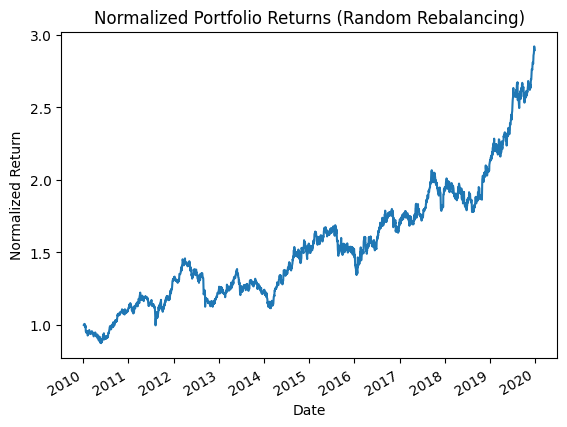

In [168]:
# Plot the normalized portfolio returns
normalized_portfolio_returns_random.plot(title='Normalized Portfolio Returns (Random Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.show()

You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite

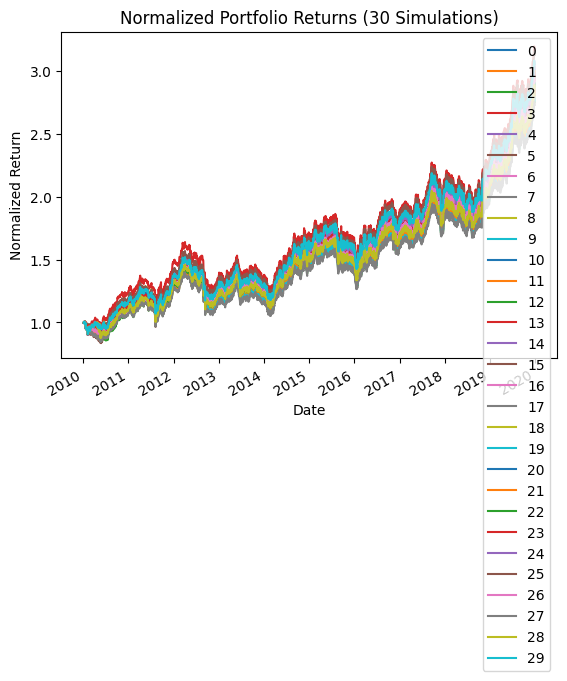

In [174]:
simulated_portfolios = []
num_simulations = 30

for i in range(num_simulations):
    # Generate a random binary array
    binary_array = random_array()
    
    # Calculate the random weights based on the binary array
    weights_df_random = random_weights(returns, binary_array)
    
    # Compute the normalized portfolio returns
    normalized_portfolio_returns_random = random_weights_portfolio(returns, weights_df_random)
    
    # Store the results in the list
    simulated_portfolios.append(normalized_portfolio_returns_random)

# Convert the list of results into a DataFrame for easier analysis
simulated_portfolios_df = pd.DataFrame(simulated_portfolios).T

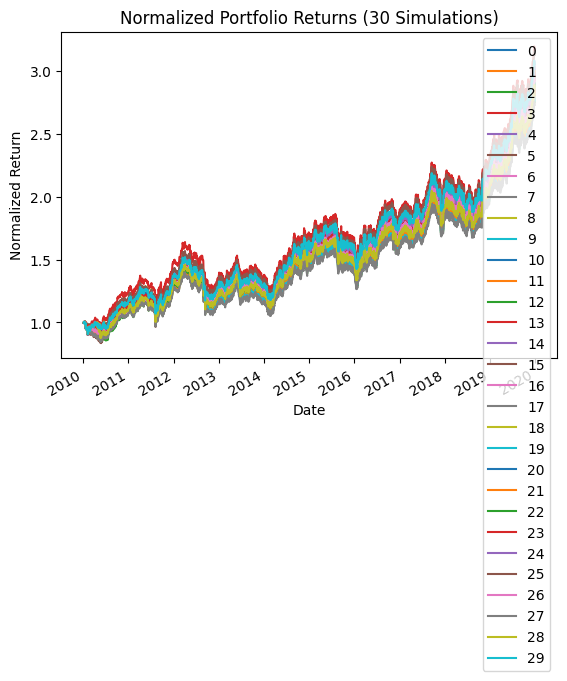

In [175]:
# Plot the results of the simulations
simulated_portfolios_df.plot(title='Normalized Portfolio Returns (30 Simulations)')
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.show()